In [1]:
using JuMP, Gurobi, GLM, DataFrames

INFO: Recompiling stale cache file /Users/Tim/.julia/lib/v0.6/JuMP.ji for module JuMP.
INFO: Recompiling stale cache file /Users/Tim/.julia/lib/v0.6/Gurobi.ji for module Gurobi.
INFO: Recompiling stale cache file /Users/Tim/.julia/lib/v0.6/GLM.ji for module GLM.
INFO: Recompiling stale cache file /Users/Tim/.julia/lib/v0.6/DataFrames.ji for module DataFrames.


In [2]:
using Plots

In [3]:
using Clustering

INFO: Recompiling stale cache file /Users/Tim/.julia/lib/v0.6/Clustering.ji for module Clustering.


In [293]:
function ClusterTree(X,c_p,max_depth,K)
    t_mx = 2^(max_depth+1)-1
    t = 1:t_mx
    Branches = t[1:2^(max_depth)-1]
    Leaves = t[2^(max_depth):end]
    
    P = Dict()
    P[1] = []
    P_L = Dict()
    P_L[1] = []
    P_R = Dict()
    P_R[1] = []


    for t in 2:t_mx
        par = Int(floor(t/2))
        P[t] = par
        if (par == t/2)
            P_L[t] = push!(copy(P_L[par]), par)
            P_R[t] = P_R[par]
        else
            P_R[t] = push!(copy(P_R[par]), par)
            P_L[t] = P_L[par]
        end
    end

    n,p = size(X)
    
    eps = zeros(p)
    for j = 1:p
        sXj = sort(X[:,j])
        diffs = sXj[2:end]-sXj[1:end-1]
        eps[j] = minimum(diffs[:,diffs != 0])
    end
    
    e_mx = maximum(eps)
    
    L_s = sum(abs.(Xnor .- mean(Xnor,1)))
    
    mod = Model(solver = GurobiSolver(OutputFlag=0))

    # Split Variables
    @variable(mod, a[j=1:p,t in Branches], Bin)
    @variable(mod, b[t in Branches] >= 0)
    @variable(mod, z[i=1:n,t in Leaves], Bin)

    # Split Constraints
    for t in Leaves
        @constraint(mod, [i=1:n,m in P_L[t]], 1 == 1)
        @constraint(mod, [i=1:n,m in P_L[t]], 
            sum(a[j,m]*(X[i,j]+eps[j]) for j = 1:p) <= b[m] + (1+e_mx)*(1-z[i,t]))
        @constraint(mod, [i=1:n,m in P_R[t]], 
            sum(a[j,m]*X[i,j] for j = 1:p) >= b[m] - (1-z[i,t])) 
    end
    @constraint(mod, zConst[i=1:n], 
        sum(z[i,t] for t in Leaves) == 1)
    
    # Complexity Variables
    @variable(mod, d[t in Branches], Bin)
    
    # Complexity Constraints
    @constraint(mod, MakeSplit1[t in Branches], 
        sum(a[j,t] for j=1:p) == d[t])
    @constraint(mod, MakeSplit2[t in Branches], 
        b[t] <= d[t])
    for t in setdiff(Branches,1)
        @constraint(mod, d[t] <= d[P[t]])
    end
    
    # Cluster Variables
    @variable(mod, μ[k = 1:K, j=1:p])
    @variable(mod, β[t in Leaves, j=1:p])
    @variable(mod, w[k = 1:K, t in Leaves], Bin)
    @variable(mod, f[i = 1:n, j = 1:p])
    
    @variable(mod, α[t in Leaves, j=1:p, k = 1:K] >= 0)
    @variable(mod, γ[t in Leaves, j=1:p, i = 1:n] >= 0)
    
    
    # Cluster Constraints ----------FIX
    for t in Leaves
        @constraint(mod, [j=1:p], β[t,j] <= d[P[t]])
    end
    
    @constraint(mod, LinearizeMean1[t in Leaves, j=1:p, k = 1:K],
        α[t,j,k] <= w[k,t])
    @constraint(mod, LinearizeMean2[t in Leaves, j=1:p, k = 1:K],
        α[t,j,k] <= μ[k,j])
    @constraint(mod, LinearizeMean3[t in Leaves, j=1:p, k = 1:K],
        α[t,j,k] >= μ[k,j]-(1-w[k,t]))
    @constraint(mod, Mean[t in Leaves, j=1:p],
        sum(α[t,j,k] for k = 1:K) == β[t,j])
    
    @constraint(mod, wConst[t in Leaves], 
        sum(w[k,t] for k = 1:K) == 1)
    
    @constraint(mod, LinearizePred1[t in Leaves, j=1:p, i = 1:n],
        γ[t,j,i] <= z[i,t])

    @constraint(mod, LinearizePred2[t in Leaves, j=1:p, i = 1:n],
        γ[t,j,i] <= β[t,j])

    @constraint(mod, LinearizePred3[t in Leaves, j=1:p, i = 1:n],
        γ[t,j,i] >= β[t,j]-(1-z[i,t]))
     
    @constraint(mod, Pred[i = 1:n, j=1:p],
        sum(γ[t,j,i] for t in Leaves) == f[i,j])
    
    # Loss Variables
    @variable(mod, L[i = 1:n, j = 1:p] >= 0)
    
    # Loss Constraints
    @constraint(mod, Loss1[i = 1:n, j = 1:p], 
        L[i,j] >= f[i,j]-X[i,j])   
    @constraint(mod, Loss2[i=1:n, j=1:p], 
        L[i,j] >= -f[i,j]+X[i,j])   
    
    @objective(mod, Min, (1/L_s)*sum(L[i,j] for i=1:n, j=1:p) + 
        c_p*sum(d[t] for t in Branches));

    status = solve(mod)
    println("Status = ", status)
    z_soln = getvalue(z)
    μ_soln = getvalue(μ)
    a_soln = getvalue(a)
    b_soln = getvalue(b)
    d_soln = getvalue(d)
    w_soln = getvalue(w)
    obj = getobjectivevalue(mod)
    z_soln, μ_soln, a_soln, b_soln, w_soln, d_soln, obj
end;

In [393]:
srand(1234)

n1 = 10
μ1 = [10,10]
σ1 = (1/1.9)
x1 = (μ1.+σ1*randn(n1,2)')'
y1 = 0*ones(Int, n1,1)

n2 = 10
μ2 = [0,5]
σ2 = (1/1.15)
x2 = (μ2.+σ2*randn(n2,2)')'
y2 = 1*ones(Int,n2,1)

n3 = 8
μ3 = [10,0]
σ3 = (1/0.9)
x3 = (μ3.+σ3*randn(n3,2)')'
y3 = 2*ones(Int,n3,1)

n4 = 8
μ4 = [5,5]
σ4 = (1/0.9)
x4 = (μ4.+σ4*randn(n4,2)')'
y4 = 3*ones(Int,n4,1)

n = n1+n2+n3+n4
X = [x1;x2;x3;x4]
Y = [y1;y2;y3;y4];

In [394]:
mx_X = maximum(X,1)
mn_X = minimum(X,1)
Xnor = (X .- mx_X)./(mn_X .- mx_X);

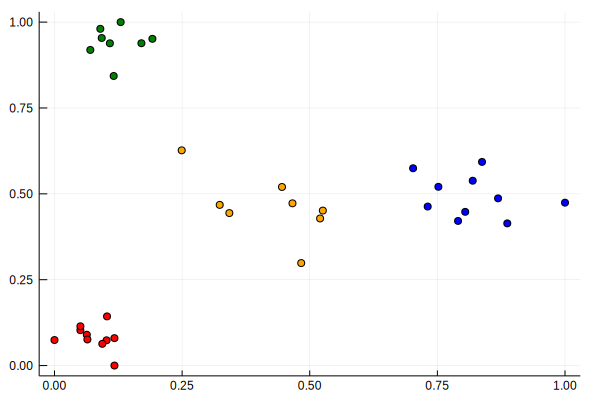

In [396]:
mcols = [:red, :blue, :green, :orange]
scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[Y+1], leg=false)

In [403]:
c_p = 0
max_depth = 2
K = 4
z_soln, μ_soln, a_soln, b_soln, w_soln, d_soln, obj = ClusterTree(Xnor,c_p,max_depth,K);

Academic license - for non-commercial use only
Status = Optimal


In [404]:
which_t = [find(z_soln[i,:])[1] for i = 1:n]
t_to_k = [find(w_soln[:,:][:,i])[1] for i = 1:length(w_soln[1,:])]
assigments = t_to_k[which_t];

In [405]:
t_mx = 2^(max_depth+1)-1
t = 1:t_mx
Branches = t[1:2^(max_depth)-1]
Leaves = t[2^(max_depth):end];

In [406]:
#xs = linspace(0,1,100)
#ys = (b_soln[1]-a_soln[1,1]*xs)./a_soln[2,1]

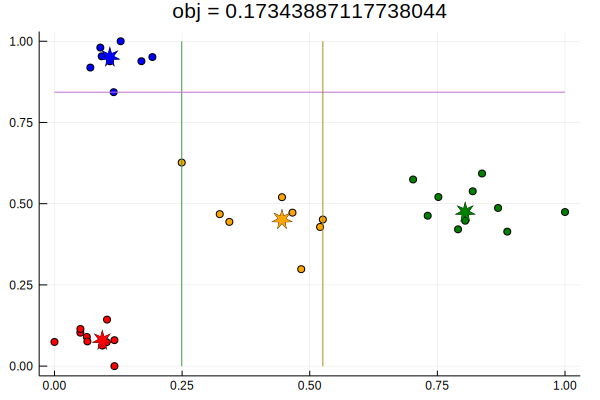

In [417]:
mcols = [:red, :blue, :green, :orange]
scatter(Xnor[:,1],Xnor[:,2], markercolor=mcols[assigments], 
    leg=false, title = "obj = $obj")
scatter!(μ_soln[:,1],μ_soln[:,2], markercolor=mcols, m=[:star7], markersize = 10)

p = 2
for t in Branches
    if (a_soln[1,t] > 0) # Vertical Split
        xs = b_soln[t]*ones(100)
        ys = linspace(0,1,100)
    else              # Horizontal Split
        xs = linspace(0,1,100)
        ys = b_soln[t]*ones(100)
    end
    plot!(xs,ys)
end

plot!()

In [409]:
a_soln

a: 2 dimensions:
[1,:]
  [1,1] = 1.0
  [1,2] = 0.0
  [1,3] = 1.0
[2,:]
  [2,1] = 0.0
  [2,2] = 1.0
  [2,3] = 0.0

In [410]:
b_soln

b: 1 dimensions:
[1] = 0.24920513625404572
[2] = 0.8431642086845281
[3] = 0.5256810585215171

In [411]:
d_soln

d: 1 dimensions:
[1] = 1.0
[2] = 1.0
[3] = 1.0

In [412]:
t_to_k

4-element Array{Int64,1}:
 1
 2
 4
 3

In [413]:
μ_soln

4×2 Array{Float64,2}:
 0.093659  0.079858
 0.108524  0.95135 
 0.804528  0.474275
 0.445641  0.451252